In [2]:
pip install tntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 3.0 MB/s 


In [1]:
import os
import random
import time
import torch
import torch.nn as nn
import numpy as np

import tntorch as tn

In [2]:
def tt_multiply(tt: tn.Tensor, tensor: torch.Tensor, shapes, in_dims):
    """
    Multiply TTTensor by any tensor of more than 1-way.
    For vectors, reshape them to matrix of shape 1 x I
    
    shapes: shapes of the intitial tensor be decomposed to
    in_dims: factors of input dimentions of initial 2D matrix
    over these dimensions, convolution is performed when multiplying
    
    returns: torch.Tensor of shape b x num_cols(tt_matrix)
    """

    assert len(tensor.shape) > 1
    assert (tt.ranks_tt is not None) # be sure that tt tensor
    assert  torch.prod(in_dims) == tensor.shape[1]

    rows = torch.prod(in_dims)
    b = tensor.reshape(-1, rows).shape[0]
    tensor = tensor.reshape(b, -1).T
    result = tensor.reshape(in_dims[0], -1)
    core = tt.cores[0].reshape(tt.cores[0].shape[0], in_dims[0], -1, tt.cores[0].shape[2])
    result = torch.einsum('id,lior->ldor', result, core)

    for d in range(1, len(tt.cores)):
        core = tt.cores[d].reshape(tt.cores[d].shape[0], in_dims[d], -1, tt.cores[d].shape[2])
        result = result.reshape(in_dims[d], -1, core.shape[0])
        result = torch.einsum('idr,riob->dob', result, core)

    return result.reshape(b, -1)

In [12]:
def test_tt_multiply():
    m = torch.rand(11 * 2, 23 * 3)
    v = torch.rand(30, 11 * 2)  # Note: batch = 30, 11 * 3 features

    input_dims = [11, 2]
    output_dims = [23, 3]
    ranks = [50]

    tt = tn.Tensor(m.reshape(11, 2, 23, 3).permute(0, 2, 1, 3).reshape(11 * 23, 2 * 3), ranks_tt=[40])

    a = tt.torch().reshape(11, 23, 2, 3).permute(0, 2, 1, 3).reshape(11 * 2, 23 * 3)

    b = tt_multiply(tt, v, shapes = (11 * 3, 23 * 2), in_dims = torch.tensor([11, 2]))

    assert torch.allclose((v @ a), b), f'error: {torch.norm((v @ a) -  b)}'


In [ ]:
def test_tt_multiply():
    m = torch.rand(11 * 2, 23 * 3)
    v = torch.rand(30, 11 * 2)  # Note: batch = 30, 11 * 3 features

    input_dims = [11, 2]
    output_dims = [23, 3]
    ranks = [50]

    tt = tn.Tensor(m.reshape(11, 2, 23, 3).permute(0, 2, 1, 3).reshape(11 * 23, 2 * 3), ranks_tt=[40])

    a = tt.torch().reshape(11, 23, 2, 3).permute(0, 2, 1, 3).reshape(11 * 2, 23 * 3)

    b = tt_multiply(tt, v, shapes = (11 * 3, 23 * 2), in_dims = torch.tensor([11, 2]))

    assert torch.allclose((v @ a), b), f'error: {torch.norm((v @ a) -  b)}'


In [33]:
def test_tt_multiply1():
    v = torch.rand(30, 768)
    m = torch.rand(768, 3072)
    m_new = m.reshape(32, 48, 48, 32)
    
    in_dims = torch.tensor([4, 6, 8, 4])
    out_dims = torch.tensor([8, 8, 6, 8])
    
    print (torch.allclose(m_new.permute(0, 2, 1, 3), m_new.permute(0, 2, 1, 3).permute(0, 1, 2, 3)))
    print (torch.allclose(m, m_new.permute(0, 2, 1, 3).permute(0, 1, 2, 3).reshape(768, 3072)))
    tt = tn.Tensor(m_new, ranks_tt=[30, 40, 50])
    
    for elem in tt.cores:
        print (type(elem))
        print (elem.shape)

    restore = tt.torch()
    

In [36]:
v = torch.rand(30, 768)
m = torch.rand(768, 3072)
m_new = m.reshape(24, 32, 64, 48)

In [37]:
m_new = m.reshape(24, 32, 64, 48)
tt = tn.Tensor(m_new, ranks_tt=[20, 30, 40])

In [38]:
test_tt_multiply1()

True
False
<class 'torch.Tensor'>
torch.Size([1, 32, 30])
<class 'torch.Tensor'>
torch.Size([30, 48, 40])
<class 'torch.Tensor'>
torch.Size([40, 48, 32])
<class 'torch.Tensor'>
torch.Size([32, 32, 1])


In [6]:
import tntorch as tn
v = torch.rand(30, 768)
m = torch.rand(768, 3072)
m_new = m.reshape((32, 48, 48, 32))
print (torch.allclose(m, m_new.reshape(768, 3072), atol=1e-05))
tt = tn.Tensor(m_new, ranks_tt=[3, 4, 5])

restore = tt.torch()

print (torch.allclose(m, tt.torch().reshape((768, 3072)), atol=1e-01))

for elem in tt.cores:
    print (type(elem))
    print (elem.shape)

True
False
<class 'torch.Tensor'>
torch.Size([1, 32, 3])
<class 'torch.Tensor'>
torch.Size([3, 48, 4])
<class 'torch.Tensor'>
torch.Size([4, 48, 5])
<class 'torch.Tensor'>
torch.Size([5, 32, 1])


In [7]:
a = v @ tt.torch().reshape((768, 3072))
a[:10, 5]

tensor([190.1586, 179.5659, 192.6148, 187.1103, 184.4869, 188.0385, 197.2183,
        191.4984, 189.8160, 198.3449])

In [8]:
res = tt_multiply(tt, v, shapes = (32, 48, 48, 32), in_dims = torch.tensor([4, 6, 8, 4]))

In [9]:
res[:10, 5]

tensor([192.1574, 181.1985, 194.5892, 188.8939, 186.2896, 189.8886, 199.2628,
        193.4445, 191.9202, 200.3451])

In [10]:
torch.norm((v @ tt.torch().reshape((768, 3072)))- res)/torch.norm(res)

tensor(0.0066)

In [11]:
print (torch.allclose(v @ tt.torch().reshape(768, 3072), res, atol=1e-01))


False


## TTM

In [ ]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

In [ ]:
v = torch.rand(30, 768)
m = torch.rand(768, 3072)
   
input_dims = [4, 6, 8, 4]
output_dims = [8, 8, 6, 8]
ranks = [50, 50, 50]

ttm = tn.TTMatrix(m, input_dims=input_dims, output_dims=output_dims, ranks=ranks)
assert torch.allclose(v @ ttm.torch(), tn.tt_multiply(ttm, v))



In [ ]:
for elem in tt.cores:
    print (type(elem))
    print (elem.shape)

<class 'torch.Tensor'>
torch.Size([1, 32, 3])
<class 'torch.Tensor'>
torch.Size([3, 48, 4])
<class 'torch.Tensor'>
torch.Size([4, 48, 5])
<class 'torch.Tensor'>
torch.Size([5, 32, 1])


In [ ]:
m = torch.rand(3072, 768) #8*4, 6*8, 6*8, 8*4
v = torch.rand(30, 3072)  # Note: batch = 30, 11 * 3 features
print ((v@m).shape)
v.shape

torch.Size([30, 768])


torch.Size([30, 3072])

In [ ]:
import tntorch as tn
tt = tn.Tensor(m.reshape(32, 48, 48, 32), ranks_tt=[32, 36, 32])

In [ ]:
tt_res = tt
tt_res.cores = [torch.reshape(tt.cores[0],(1, 8, 4, 32)), torch.reshape(tt.cores[1], (32, 6, 8, 36)), torch.reshape(tt.cores[2], (36, 6, 8, 32)), torch.reshape(tt.cores[3], (32, 8, 4, 1))]

input_dims = torch.tensor([8, 6, 6, 8])
output_dims = torch.tensor([4, 8, 8, 4])

In [ ]:
tt_multiply(ttm, v)

torch.Size([8, 11520]) torch.Size([1, 8, 4, 32])
result shape torch.Size([1, 11520, 4, 32])
torch.Size([6, 7680, 32]) torch.Size([32, 6, 8, 36])
result shape torch.Size([7680, 8, 36])
torch.Size([8, 7680, 36]) torch.Size([36, 8, 6, 32])
result shape torch.Size([7680, 6, 32])
torch.Size([8, 5760, 32]) torch.Size([32, 8, 4, 1])
result shape torch.Size([5760, 4, 1])
torch.Size([30, 768])


tensor([[758.3635, 757.5698, 762.0194,  ..., 760.6479, 753.1539, 758.3381],
        [762.9049, 765.4019, 768.4266,  ..., 762.6346, 759.7394, 762.8599],
        [785.9296, 786.1127, 789.0124,  ..., 786.3926, 781.9754, 783.9235],
        ...,
        [769.3828, 769.9366, 775.4473,  ..., 770.8221, 767.1511, 768.8950],
        [772.4765, 774.3235, 780.9059,  ..., 773.8949, 769.3389, 773.3456],
        [762.5847, 765.2134, 768.9113,  ..., 763.8503, 761.7515, 759.0067]])

In [ ]:
def tt_multiply(tt_matrix: tn.TTMatrix, tensor: torch.Tensor):
    """
    Multiply TTMatrix by any tensor of more than 1-way.
    For vectors, reshape them to matrix of shape 1 x I
    returns: torch.Tensor of shape b x num_cols(tt_matrix)
    """

    assert len(tensor.shape) > 1

    rows = torch.prod(tt_matrix.input_dims)
    b = tensor.reshape(-1, rows).shape[0]
    tensor = tensor.reshape(b, -1).T
    result = tensor.reshape(tt_matrix.input_dims[0], -1)
    print (result.shape, tt_matrix.cores[0].shape)
    result = torch.einsum('id,lior->ldor', result, tt_matrix.cores[0])
    print ("result shape", result.shape)

    for d in range(1, tt_matrix.d):
        result = result.reshape(tt_matrix.input_dims[d], -1, tt_matrix.cores[d].shape[0])
        print (result.shape, tt_matrix.cores[d].shape)
        result = torch.einsum('idr,riob->dob', result, tt_matrix.cores[d])
        print ("result shape", result.shape)
    print (result.reshape(b, -1).shape)

    return result.reshape(b, -1)

In [ ]:
fc_w_new.weight.shape

**singular values**

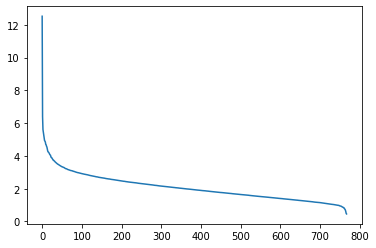

In [ ]:
plt.plot(s)
plt.show()

In [ ]:
{6:(0, 2, 4, 1, 3, 5), 8:(0, 2, 4, 6, 1, 3, 5, 7), 10:(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}

{6: (0, 2, 4, 1, 3, 5),
 8: (0, 2, 4, 6, 1, 3, 5, 7),
 10: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}

In [ ]:
a = colbert.bert.encoder.layer[4].intermediate.dense(input_)

NameError: name 'input_' is not defined

In [ ]:
b = fc_w_new(input_)

NameError: name 'input_' is not defined

In [ ]:
from tensorly.tt_matrix import TTMatrix

perms = {6:(0, 2, 4, 1, 3, 5), 8:(0, 2, 4, 6, 1, 3, 5, 7), 10:(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}

for rank in [ 20, 30, 40, 50]:
    m = colbert.bert.encoder.layer[4].intermediate.dense
    input_ = torch.randn(batch_size, in_)
    m_ttm = FactorizationTTMLinear(in_, out_, rank=rank, max_core_dim_product =rank)
    m_ttm.fill_with_pretrained_matrix(fc_w)
    restored_weight = TTMatrix([elem.data for elem in m_ttm.ttm.tt.cores]).to_tensor()
    print (restored_weight.shape)
    restored_weight = restored_weight.permute(perms[(len(restored_weight.shape))])
    print (restored_weight.shape)
    print (torch.norm(fc_w_new.weight - restored_weight.reshape(fc_w_new.weight.shape))/torch.norm(fc_w_new.weight))
    print (restored_weight.shape)
    c = m_ttm(input_)
    print (torch.norm(a-c)/torch.norm(a))
    print ("\n\n\n")

In [ ]:
torch.norm(a-c)

tensor(771.9188, grad_fn=<CopyBackwards>)

In [ ]:
torch.norm(a-b)

tensor(0., grad_fn=<CopyBackwards>)

In [ ]:
factors = tensor_train_matrix(B, rank = [1, 60, 90, 1])

NameError: name 'tensor_train_matrix' is not defined

In [ ]:
for elem in factors.factors:
    print (elem.shape)

torch.Size([1, 8, 16, 60])
torch.Size([60, 12, 12, 90])
torch.Size([90, 8, 16, 1])


In [ ]:
new_B = factors.to_tensor()
new_B.shape

torch.Size([8, 16, 12, 8, 12, 16])

In [ ]:
B.shape

torch.Size([8, 16, 12, 8, 12, 16])

In [ ]:
np.linalg.norm(new_B - B)/np.linalg.norm(B)

0.70110387

In [ ]:
for elem in factors:
    print (elem.shape)

torch.Size([1, 8, 8, 60])
torch.Size([60, 16, 12, 90])
torch.Size([90, 12, 16, 1])


In [ ]:
fc_w.shape[1],fc_w.shape[0]

(768, 3072)

In [ ]:
from src.ttm_linear.ttm_linear.ttm_linear import FactorizationTTMLinear

In [ ]:
B.shape

torch.Size([32, 48, 48, 32])

In [ ]:
errs2 = []
ranks2 = []
c_rates2 = []

import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')


B = fc_w
B = B.reshape((32, 48, 48, 32))




err = 10.0
rank1 = 5
rank2 = 5
step = 10
compression_rate = 0.0
while (compression_rate < 0.7):
    factors = tensor_train(B, rank = [1, rank1, rank2, rank1, 1])
    new_B = factors.to_tensor()
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs2.append(err)
    ranks2.append(rank1)
    c_rates2.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

In [ ]:
errs3 = []
ranks3 = []
c_rates3 = []

import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')


B = fc_w
B = B.reshape(128, 144, 128)




err = 10.0
rank1 = 5
rank2 = 5
step = 10
compression_rate = 0.0
while (compression_rate < 0.7):
    factors = tensor_train(B, rank = [1, rank1, rank2, 1])
    new_B = factors.to_tensor()
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs3.append(err)
    ranks3.append(rank1)
    c_rates3.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

[torch.Size([1, 128, 5]), torch.Size([5, 144, 5]), torch.Size([5, 128, 1])]
err  0.9830911 compression_rate  0.002068413628472222 rank  5 5
[torch.Size([1, 128, 5]), torch.Size([5, 144, 15]), torch.Size([15, 128, 1])]
err  0.97657156 compression_rate  0.005662706163194444 rank  5 15
[torch.Size([1, 128, 15]), torch.Size([15, 144, 15]), torch.Size([15, 128, 1])]
err  0.9700918 compression_rate  0.015360514322916666 rank  15 15
[torch.Size([1, 128, 15]), torch.Size([15, 144, 25]), torch.Size([25, 128, 1])]
err  0.96239424 compression_rate  0.025058322482638888 rank  15 25
[torch.Size([1, 128, 25]), torch.Size([25, 144, 25]), torch.Size([25, 128, 1])]
err  0.9518059 compression_rate  0.04085964626736111 rank  25 25
[torch.Size([1, 128, 25]), torch.Size([25, 144, 35]), torch.Size([35, 128, 1])]
err  0.94061637 compression_rate  0.056660970052083336 rank  25 35
[torch.Size([1, 128, 35]), torch.Size([35, 144, 35]), torch.Size([35, 128, 1])]
err  0.92628205 compression_rate  0.078565809461805

In [ ]:
import matplotlib.pyplot as plt
  

# plot lines
plt.plot(c_rates, errs, label = "SVD")
plt.plot(c_rates3, errs3,  label = "TT 3 cores, 128*144*128 ")
plt.plot(c_rates3, errs3,  label = "TT 4 cores, 32*48*48*32 ")
plt.plot(c_rates1, errs1,  label = "TT 6 cores, 8*12*16*16*12*8")
#plt.plot(errs1_m, c_rates1_m, label = "TTM (permute + reshape)")
plt.ylabel('errors')
plt.xlabel('compression rate')
plt.legend()
plt.savefig("TT + SVD")
plt.show()

NameError: name 'c_rates' is not defined

In [ ]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

errs1 = []
ranks1 = []
c_rates1 = []

B = fc_w
B = B.reshape(8, 12, 16, 16, 12, 8)




err = 10.0
rank1 = 5
rank2 = 5
step = 10
compression_rate = 0.0
while (compression_rate < 0.7):
    factors = tensor_train(B, rank = [1, rank1, rank2, rank2, rank2, rank1, 1])
    new_B = factors.to_tensor()
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs1.append(err)
    ranks1.append(rank1)
    c_rates1.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 335]), torch.Size([335, 16, 96]), torch.Size([96, 12, 8]), torch.Size([8, 8, 1])]
err  0.5942937 compression_rate  0.4440646701388889 rank  335 335
[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 345]), torch.Size([345, 16, 96]), torch.Size([96, 12, 8]), torch.Size([8, 8, 1])]
err  0.5857147 compression_rate  0.4570855034722222 rank  335 345
[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 345]), torch.Size([345, 16, 96]), torch.Size([96, 12, 8]), torch.Size([8, 8, 1])]
err  0.5857147 compression_rate  0.4570855034722222 rank  345 345
[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 355]), torch.Size([355, 16, 96]), torch.Size([96, 12, 8]), torch.Size([8, 8, 1])]
err  0.5772192 compression_rate  0.4701063368055556 rank  345 355
[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 355]), torch.Size([355, 16, 96]), torch.Size([96, 12, 8]), torc

In [ ]:
B = fc_w
B = B.reshape((32, 48, 48, 32))

In [ ]:
np.prod(fc_w.shape)

2359296

In [ ]:
D_rest = tl.tt_tensor.tt_to_tensor(factors)
err = np.linalg.norm(D_rest - D)/np.linalg.norm(D)
err

0.81661785